In [14]:
!pip install transformers==4.45.0 --upgrade --force-reinstall


  Using cached transformers-4.45.0-py3-none-any.whl.metadata (44 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached regex-2025.11.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.20.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.6.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [3]:
!ls /content/drive/MyDrive/dataset/ai_challenger_caption_validation_20170910/

'caption_validation_annotations_20170910 (1).json'   COPYRIGHT
 caption_validation_annotations_20170910.json	     README
 caption_validation_images_20170910


In [4]:
img_paths = glob.glob('/content/drive/MyDrive/dataset/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()

img_paths = img_paths[:2000]
img_paths[:2]

['/content/drive/MyDrive/dataset/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/0003a0755539c426ecfc7ed79bc74aeea6be740b.jpg',
 '/content/drive/MyDrive/dataset/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/000420107b8abee7c2f08bb21e4444a9d00c9323.jpg']

In [5]:
validation_annotations = json.load(
    open('/content/drive/MyDrive/dataset/ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)


validation_annotations[:2]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [6]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}

In [7]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

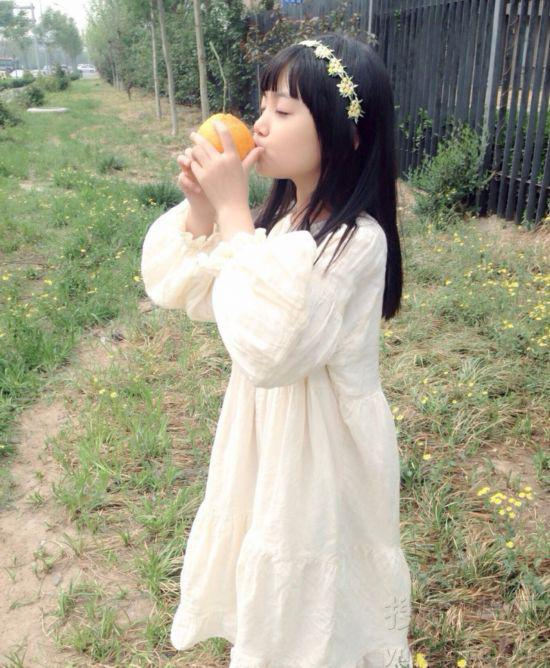

In [8]:
Image.open(img_paths[0])

In [9]:
img_captions[0]

'一个穿着裙子的女孩双手拿着东西站在宽阔的草地上'

# 加载CLIP模型

In [11]:
!pip install modelscope

In [12]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

# model = ChineseCLIPModel.from_pretrained("./model/chinese-clip-vit-base-patch16") # 中文clip模型
# processor = ChineseCLIPProcessor.from_pretrained("./model/chinese-clip-vit-base-patch16") # 预处理

# 1. 加载模型与预处理器
# model_name = "OFA-Sys/chinese-clip-vit-base-patch16"
# processor = ChineseCLIPProcessor.from_pretrained(model_name, cache_dir="/content/drive/MyDrive/hf_models")
# model = ChineseCLIPModel.from_pretrained(model_name, cache_dir="/content/drive/MyDrive/hf_models", add_pooling_layer=True )

from modelscope import ChineseCLIPProcessor, ChineseCLIPModel

model = ChineseCLIPModel.from_pretrained("AI-ModelScope/chinese-clip-vit-base-patch16")
processor = ChineseCLIPProcessor.from_pretrained("AI-ModelScope/chinese-clip-vit-base-patch16", clean_up_tokenization_spaces=True)

# 图像编码

In [13]:
img_image_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]

    if len(imgs) == 0:
        break

    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    break

img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

/tmp/ipython-input-1917125981.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/101 [00:00<?, ?it/s]

In [14]:
img_image_feat.shape # 20张图片 512 维度

(20, 512)

# 文本编码

In [28]:

img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break

    inputs = processor(text=texts, padding=True, return_tensors="pt")

    with torch.no_grad():
      text_features = model.get_text_features(**inputs)

      text_features = text_features.data.numpy()
      img_texts_feat.append(text_features)
    break

img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

/tmp/ipython-input-399190495.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/101 [00:00<?, ?it/s]

In [29]:
img_texts_feat.shape

(20, 512)

# 尝试1：相似度计算

In [30]:
query_idx = 0

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][1:4]

输入文本:  一个穿着裙子的女孩双手拿着东西站在宽阔的草地上


([], [])

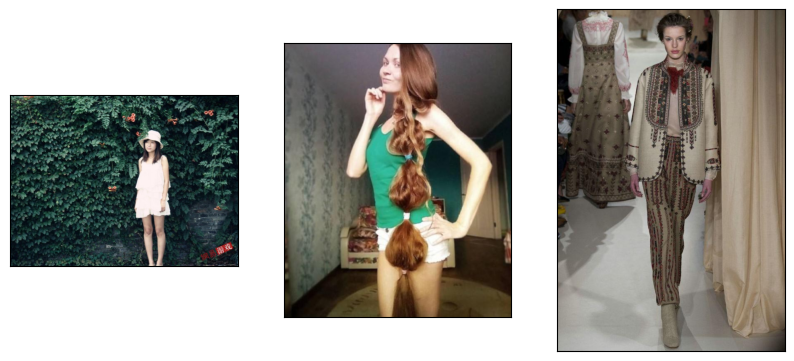

In [31]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [32]:
query_idx = 10

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['足球场上两个穿着球服的男人在争抢足球', '绿茵茵的球场上两个人前面有两个穿着不同球衣的男人在踢足球', '敞亮的房屋里一个趴在床边的小孩和一个躺着的小孩在看着同一个手机']


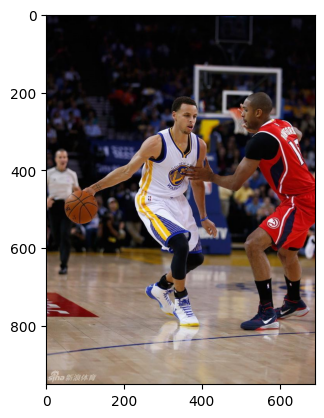

In [33]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [34]:
import jieba

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


In [35]:
jieba.lcut('今天天气很好，心情也很好。')

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.850 seconds.
DEBUG:jieba:Loading model cost 0.850 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [36]:
jieba.lcut(img_captions[0])

['一个',
 '穿着',
 '裙子',
 '的',
 '女孩',
 '双手',
 '拿',
 '着',
 '东西',
 '站',
 '在',
 '宽阔',
 '的',
 '草地',
 '上']

In [49]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [51]:
img_captions2words

['一个',
 '穿着',
 '裙子',
 '的',
 '女孩',
 '双手',
 '拿',
 '着',
 '东西',
 '站',
 '在',
 '宽阔',
 '的',
 '草地',
 '上',
 '大厅',
 '里',
 '的',
 '两个',
 '人',
 '旁边',
 '站',
 '着',
 '两个',
 '穿着',
 '古装',
 '的',
 '人',
 '道路',
 '上',
 '一群',
 '人',
 '的',
 '旁边',
 '有',
 '一个',
 '右手',
 '比',
 '着',
 '手势',
 '的',
 '女人',
 '在',
 '说话',
 '绿茵茵',
 '的',
 '球场上',
 '两个',
 '人',
 '前面',
 '有',
 '两个',
 '穿着',
 '不同',
 '球衣',
 '的',
 '男人',
 '在',
 '踢足球',
 '足球场',
 '上',
 '两个',
 '穿着',
 '球服',
 '的',
 '男人',
 '在',
 '争抢',
 '足球',
 '房屋',
 '前有',
 '四个',
 '拿',
 '着',
 '相机',
 '的',
 '男人',
 '在',
 '给',
 '一个',
 '身穿',
 '裙子',
 '的',
 '女人',
 '拍照',
 '街道',
 '上',
 '站',
 '着',
 '一位',
 '右肩',
 '背着',
 '鼓',
 '的',
 '小孩',
 '和',
 '一位',
 '脸上',
 '画',
 '着',
 '脸谱',
 '的',
 '男人',
 '一个',
 '扎',
 '着',
 '辫子',
 '的',
 '女人',
 '左手',
 '叉',
 '着',
 '腰站',
 '在',
 '房屋内',
 '房间',
 '里',
 '有',
 '一个',
 '披',
 '着',
 '头发',
 '的',
 '女人',
 '和',
 '一个',
 '人',
 '在',
 '下围棋',
 '工作室',
 '里',
 '有',
 '一个',
 '戴着',
 '眼镜',
 '的',
 '人',
 '在',
 '演奏',
 '乐器',
 '一个',
 '男人',
 '前面',
 '有',
 '两个',
 '穿着',
 '球衣',
 '的',
 '男人',
 '在',
 '平坦',
 '的

In [52]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [53]:
img_captions2words[:10]

['游戏', '进行', '锻炼', '勾肩搭背', '广告牌', '品尝', '走廊', '手牵着', '花园', '健壮']

In [54]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break

    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)

img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

/tmp/ipython-input-3640130202.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/68 [00:00<?, ?it/s]

# 尝试2：标签相似度计算

In [57]:
query_idx = 10

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

In [59]:
len(img_texts_feat)

1353

文本识别结果:  ['厨房', '小腹', '做饭', '做菜', '光着', '腰边']


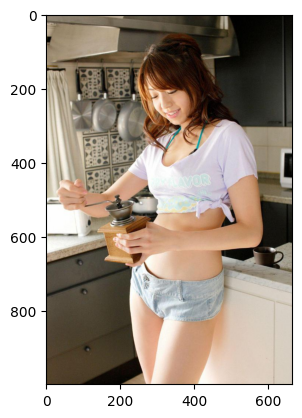

In [43]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])